## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2018-04-10 17:55:40--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/DP9WWklt8DTVDuXTvcwmKQaku6S8gdLiZ6ZhvCmWhS99rooKJIIHljjUxLDVb1Hb/file [following]
--2018-04-10 17:55:41--  https://dl.dropboxusercontent.com/content_link/DP9WWklt8DTVDuXTvcwmKQaku6S8gdLiZ6ZhvCmWhS99rooKJIIHljjUxLDVb1Hb/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.6, 2620:100:6021:6::a27d:4106
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17887724 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  17.06M  9.60MB/s    in 1.8s    

2018-04-10 17:55:44 

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/penguin138/.virtualenvs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/penguin138/.virtualenvs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


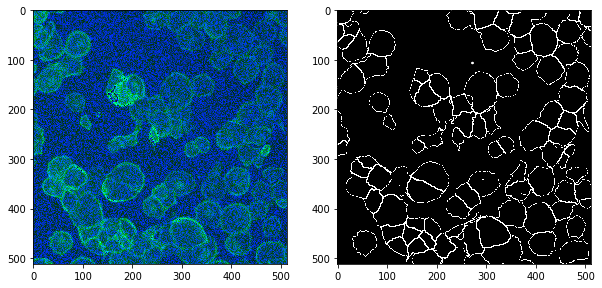

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from PIL import Image
import glob
import os
import random
from tensorboardX import SummaryWriter
from IPython import display

In [4]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

# Custom subclass of torch.utils.data.Dataset
(to be able to perform same random transforms on image and its target segmentation)

In [5]:
class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, first_images_path, second_images_path, transforms):
        self.internal_dataset = list(zip(self.__dataset(first_images_path),
                                         self.__dataset(second_images_path)))
        self.transforms = transforms
        self.transforms_applied_to_mask = set([torchvision.transforms.CenterCrop,
                                               torchvision.transforms.FiveCrop,
                                               torchvision.transforms.RandomCrop,
                                               torchvision.transforms.RandomHorizontalFlip,
                                               torchvision.transforms.RandomResizedCrop,
                                               torchvision.transforms.RandomRotation,
                                               torchvision.transforms.RandomVerticalFlip,
                                               torchvision.transforms.TenCrop,
                                               torchvision.transforms.Resize,
                                               torchvision.transforms.ToPILImage,
                                               torchvision.transforms.ToTensor,
                                               torchvision.transforms.Lambda])

    def __getitem__(self, idx):
        image, mask = self.internal_dataset[idx]
        for transform in self.transforms:
            state = random.getstate()
            np_state = np.random.get_state()
            image = transform(image)
            if self.__applies_to_mask(transform):
                np.random.set_state(np_state)
                random.setstate(state)
                mask = transform(mask)          
        return image, mask
   

    def __dataset(self, path):
        for file in sorted(glob.iglob(os.path.join(path, "*.*"))):
            image = Image.open(file)
            yield image
    
    def __applies_to_mask(self, transform):
        return transform.__class__ in self.transforms_applied_to_mask
            
    def __len__(self):
        return len(self.internal_dataset)

# Drag n drop solution for a bug in torchvision.transforms.Pad

In [6]:
# copied from torchvision repo to remove bug in Image.fromarray() 
# that caused ground truth masks to become corrupted due to improper usage of fromarray with grayscale images.
import numbers
import collections
try:
    import accimage
except ImportError:
    accimage = None

def _is_pil_image(img):
    if accimage is not None:
        return isinstance(img, (Image.Image, accimage.Image))
    else:
        return isinstance(img, Image.Image)

def pad(img, padding, fill=0, padding_mode='constant'):
    """Pad the given PIL Image on all sides with speficified padding mode and fill value.
    Args:
        img (PIL Image): Image to be padded.
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill: Pixel fill value for constant fill. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
            This value is only used when the padding_mode is constant
        padding_mode: Type of padding. Should be: constant, edge, reflect or symmetric. Default is constant.
            constant: pads with a constant value, this value is specified with fill
            edge: pads with the last value on the edge of the image
            reflect: pads with reflection of image (without repeating the last value on the edge)
                padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
                will result in [3, 2, 1, 2, 3, 4, 3, 2]
            symmetric: pads with reflection of image (repeating the last value on the edge)
                padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
                will result in [2, 1, 1, 2, 3, 4, 4, 3]
    Returns:
        PIL Image: Padded image.
    """
    if not _is_pil_image(img):
        raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

    if not isinstance(padding, (numbers.Number, tuple)):
        raise TypeError('Got inappropriate padding arg')
    if not isinstance(fill, (numbers.Number, str, tuple)):
        raise TypeError('Got inappropriate fill arg')
    if not isinstance(padding_mode, str):
        raise TypeError('Got inappropriate padding_mode arg')

    if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
        raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                         "{} element tuple".format(len(padding)))

    assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric'], \
        'Padding mode should be either constant, edge, reflect or symmetric'

    if padding_mode == 'constant':
        return ImageOps.expand(img, border=padding, fill=fill)
    else:
        if isinstance(padding, int):
            pad_left = pad_right = pad_top = pad_bottom = padding
        if isinstance(padding, collections.Sequence) and len(padding) == 2:
            pad_left = pad_right = padding[0]
            pad_top = pad_bottom = padding[1]
        if isinstance(padding, collections.Sequence) and len(padding) == 4:
            pad_left = padding[0]
            pad_top = padding[1]
            pad_right = padding[2]
            pad_bottom = padding[3]

        img = np.array(img)
        # RGB image
        if len(img.shape) == 3:
            img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), padding_mode)
        # Grayscale image
        if len(img.shape) == 2:
            img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), padding_mode)
            img.astype('uint8') # wasn't here before
            return Image.fromarray(img, "L") # there was no "L" (bug)
        return Image.fromarray(img)

class Pad(object):
    """Pad the given PIL Image on all sides with the given "pad" value.
    Args:
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill: Pixel fill value for constant fill. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
            This value is only used when the padding_mode is constant
        padding_mode: Type of padding. Should be: constant, edge, reflect or symmetric. Default is constant.
            constant: pads with a constant value, this value is specified with fill
            edge: pads with the last value at the edge of the image
            reflect: pads with reflection of image (without repeating the last value on the edge)
                padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
                will result in [3, 2, 1, 2, 3, 4, 3, 2]
            symmetric: pads with reflection of image (repeating the last value on the edge)
                padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
                will result in [2, 1, 1, 2, 3, 4, 4, 3]
    """

    def __init__(self, padding, fill=0, padding_mode='constant'):
        assert isinstance(padding, (numbers.Number, tuple))
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']
        if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
            raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                             "{} element tuple".format(len(padding)))

        self.padding = padding
        self.fill = fill
        self.padding_mode = padding_mode

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.
        Returns:
            PIL Image: Padded image.
        """
        return pad(img, self.padding, self.fill, self.padding_mode)

    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.padding, self.fill, self.padding_mode)

# Training and evaluation functions

In [7]:
def update_graph(all_metrics, train_epoch_size, val_epoch_size, subplots_layout=(1, 2), 
                 figsize=(20, 10), log_scale=False, additional_info_fn=None):
    display.clear_output(wait=True)
    fig, axes = plt.subplots(*subplots_layout, figsize=figsize)
    fig.subplots_adjust(hspace=100)
    if log_scale:
        plt.yscale('log')
    width = axes.shape[0]
    height = 1
    if len(axes.shape) > 1:
        height = axes.shape[1]
    for idx, title in enumerate(all_metrics):
        i = idx // width
        j = idx % width
        for label in all_metrics[title]:
            metric_values = all_metrics[title][label]
            epoch_size = train_epoch_size
            if label == "valid":
                epoch_size = val_epoch_size
            epoch_mean_values = []
            for idx in range(0, len(metric_values), epoch_size):
                epoch_mean_values.append(np.mean(metric_values[idx:idx + epoch_size]))
            if len(axes.shape) > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            ax.set(title=title, ylabel=title.lower(), xlabel="#iteration")
            ax.plot(epoch_mean_values, label=label)
            ax.legend()
    plt.show()
    if additional_info_fn is not None:
        additional_info_fn()

In [8]:
def print_epoch_results(epoch, num_epochs, epoch_time, batch_size,
                        epoch_size, all_metrics, iou_time, break_after=None):
    print("Epoch {} of {} time: {:.3f}s".format(
           epoch + 1, num_epochs, epoch_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(all_metrics["Loss"]["train"][-epoch_size :])))
    print("  validation loss (in-iteration): \t{:.6f}".format(
        np.mean(all_metrics["Loss"]["valid"][-epoch_size :])))
    print("  train IOU: \t\t\t{:.2f}".format(
        np.mean(all_metrics["IOU"]["train"][-epoch_size :])))
    mean_iou_valid = np.mean(all_metrics["IOU"]["valid"][-epoch_size :])
    print("  validation IOU: \t\t\t{:.2f}".format(mean_iou_valid))
    print("  IOU time: {}".format(iou_time))
    if break_after is not None and mean_iou_valid >= break_after:
        raise RuntimeError("Achieved good IOU.")

def is_torch_tensor(x):
    torch_tensor_types = set([torch.FloatTensor, torch.cuda.FloatTensor,
                              torch.DoubleTensor, torch.cuda.DoubleTensor,
                              torch.HalfTensor, torch.cuda.HalfTensor,
                              torch.ByteTensor, torch.cuda.ByteTensor,
                              torch.CharTensor, torch.cuda.CharTensor,
                              torch.ShortTensor, torch.cuda.ShortTensor,
                              torch.IntTensor, torch.cuda.IntTensor,
                              torch.LongTensor, torch.cuda.LongTensor,])
    return type(x) in torch_tensor_types
    
    
def to_np_array(x):
    if isinstance(x, list):
        return np.array(x)
    if isinstance(x, np.ndarray):
        return x
    if is_torch_tensor(x):
        return x.cpu().numpy()
    if isinstance(x, torch.autograd.Variable):
        return x.data.cpu().numpy()
    
def to_variable(x, cuda=True):
    var_x = None
    if isinstance(x, np.ndarray) or isinstance(x, list):
        var_x = torch.autograd.Variable(torch.Tensor(x))
    if is_torch_tensor(x):
        var_x = torch.autograd.Variable(x)
    if isinstance(x, torch.autograd.Variable):
        var_x = x
    if cuda:
        return var_x.cuda()
    return var_x

In [9]:
def compute_loss_and_iou(model, img_batch, mask_batch, prediction_threshold, 
                         writer=None, global_step=None, cuda=True):
    img_batch_variable = to_variable(img_batch, cuda).float()
    logits = model(img_batch_variable)
    probs = torch.nn.functional.softmax(logits, dim=1)
    prediction = probs[:, 1, ...] >= prediction_threshold
    if writer is not None and global_step % 40 == 0:
        img = torchvision.utils.make_grid(img_batch.float(),
                                          normalize=True, scale_each=True)
        mask = torchvision.utils.make_grid(mask_batch.float(), normalize=True, scale_each=True)
        pred = torchvision.utils.make_grid(prediction.data.float(), normalize=True, scale_each=True)
        writer.add_image('train_input', img, global_step=global_step)
        writer.add_image("train_target", mask, global_step=global_step)
        writer.add_image('train_pred', pred, global_step=global_step)
    logits = logits.transpose(1,3).transpose(1, 2).contiguous() 
    targets = to_variable(mask_batch, cuda).long()
    start = time.time()
    iou = calc_iou(to_np_array(prediction.float()).squeeze(), to_np_array(targets).squeeze())
    end = time.time()
    weights = to_variable([1, 22], cuda)
    return F.cross_entropy(logits.view(-1, 2), targets.view(-1), weight=weights).mean(), iou, end - start
            

In [10]:
import time

def train(model, train_dataset, val_dataset, batch_size,
          num_epochs, optimizer_type, optimizer_config={}, prediction_threshold=0.5, cuda=True,
          break_after=None):
    all_metrics = {"Loss": {"train": [], "valid": []},
                   "IOU": {"train": [], "valid": []}}
    optimizer = optimizer_type(model.parameters(), **optimizer_config)
    writer = SummaryWriter()
    global_step = 0
    if cuda:
        model = model.cuda()
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True) 
        for img_batch, mask_batch in torch.utils.data.DataLoader(train_dataset,
                                                                 batch_size=batch_size,
                                                                 shuffle=True):
            if len(img_batch.shape) == 3:
                img_batch = img_batch.expand(1, -1, -1, -1).transpose(0, 1)
            else:
                img_batch = img_batch.transpose(1, 3).transpose(2, 3)
            mask_batch = mask_batch.gt(0)
            loss, iou, iou_time = compute_loss_and_iou(model, img_batch, mask_batch,
                                                       prediction_threshold,
                                                       writer, global_step, cuda)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            all_metrics["Loss"]["train"].append(to_np_array(loss)[0])
            all_metrics["IOU"]["train"].append(iou)
            global_step += 1
        update_graph(all_metrics, len(train_dataset), len(val_dataset),
                     additional_info_fn=lambda: print_epoch_results(epoch, num_epochs,
                                                                    time.time() - start_time,
                                                                    1, len(train_dataset),
                                                                    all_metrics, iou_time))
            
        model.train(False)
        for img_batch, mask_batch in torch.utils.data.DataLoader(val_dataset,
                                                                 batch_size=batch_size,
                                                                 shuffle=True):
            if len(img_batch.shape) == 3:
                img_batch = img_batch.expand(1, -1, -1, -1).transpose(0, 1)
            else:
                img_batch = img_batch.transpose(1, 3).transpose(2, 3)
            mask_batch = mask_batch.gt(0)
            loss, iou, iou_time = compute_loss_and_iou(model, img_batch, mask_batch,
                                                       prediction_threshold, cuda=cuda)
            all_metrics["Loss"]["valid"].append(to_np_array(loss)[0])
            all_metrics["IOU"]["valid"].append(iou)
        update_graph(all_metrics, len(train_dataset), len(val_dataset),
                     additional_info_fn=
                     lambda: print_epoch_results(epoch, num_epochs,
                                                 time.time() - start_time,
                                                 1, len(val_dataset),
                                                 all_metrics, iou_time, break_after=break_after))   

In [11]:
def evaluate(model, test_dataset, names, batch_size, prediction_threshold=0.5):
    model.train(False)
    for name, (img_batch, fake_target_batch) in zip(names, 
                                                    torch.utils.data.DataLoader(test_dataset,
                                                                                batch_size=batch_size,
                                                                                shuffle=False)):
        if len(img_batch.shape) == 3:
            img_batch = img_batch.expand(1, -1, -1, -1).transpose(0, 1)
        else:
            img_batch = img_batch.transpose(1, 3).transpose(2, 3)
        logits = model(to_variable(img_batch).float().cuda())
        probs = torch.nn.functional.softmax(logits, dim=1)
        prediction = to_np_array(probs[:, 1, ...] >= prediction_threshold)
        if batch_size == 1:
            plt.figure(figsize=(10,8))
            plt.subplot(1,2,1)
            np_img_batch = (to_np_array(img_batch).squeeze() * 255).astype(np.uint8)
            np_prediction = (prediction.squeeze() * 255).astype(np.uint8)
            pred_pil = Image.fromarray(np_prediction, "L")
            pred_pil.save("test_results/" + name + ".png", format="png")
            plt.imshow(np_img_batch, cmap="gray")
            plt.subplot(1,2,2)
            plt.imshow(np_prediction, cmap="gray")
            plt.show()

# Model definition

In [12]:
class DownwardConv(nn.Module):
    """UNet convolutions block ending in maxpool"""
    def __init__(self, in_channels, out_channels, get_x_before_pool=True, use_bn=True):
        super().__init__()
        self.use_bn = use_bn
        self.get_x_before_pool = get_x_before_pool
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3))
        if use_bn:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3))
        if use_bn:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d((2, 2), stride=(2, 2))

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x)
        x_before_pool = self.relu2(x)
        x = self.pool(x_before_pool)
        if self.get_x_before_pool:
            return x, x_before_pool
        return x

class UpwardConv(nn.Module):
    """Unet convolutions block ending upconv."""
    def __init__(self, in_channels, out_channels, channels_after_up_conv, use_bn=True):
        super().__init__()
        self.use_bn = use_bn
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3))
        if use_bn:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3))
        if use_bn:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()
        self.up_conv = nn.ConvTranspose2d(out_channels,
                                          channels_after_up_conv, (2, 2), stride=(2, 2))
        if use_bn:
            self.bn3 = nn.BatchNorm2d(channels_after_up_conv)
        self.relu3 = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.bn2(x)
        x = self.relu2(x)
        x = self.up_conv(x)
        if self.use_bn:
            x = self.bn3(x)
        x = self.relu3(x)
        return x

In [13]:
class UNet(nn.Module):
    def __init__(self, num_channels=3, use_bn=True):
        super().__init__()
        self.down_conv1 = DownwardConv(num_channels, 64, use_bn)
        self.down_conv2 = DownwardConv(64, 128, use_bn)
        self.down_conv3 = DownwardConv(128, 256, use_bn)
        self.down_conv4 = DownwardConv(256, 512, use_bn)
        self.up_conv1 = UpwardConv(512, 1024, 512, use_bn)
        self.up_conv2 = UpwardConv(1024, 512, 256, use_bn)
        self.up_conv3 = UpwardConv(512, 256, 128, use_bn)
        self.up_conv4 = UpwardConv(256, 128, 64, use_bn)
        self.final_conv1 = nn.Conv2d(128, 64, (3, 3))
        self.relu1 = nn.ReLU()
        self.final_conv2 = nn.Conv2d(64, 64, (3, 3))
        self.relu2 = nn.ReLU()
        self.final_conv3 = nn.Conv2d(64, 64, (3, 3))
        self.relu3 = nn.ReLU()
        self.final_conv4 = nn.Conv2d(64, 64, (3, 3))
        self.relu4 = nn.ReLU()
        self.final_conv5 = nn.Conv2d(64, 2, (1, 1))
        self.bn1 = lambda x: x
        self.bn2 = lambda x: x
        self.bn3 = lambda x: x
        self.bn4 = lambda x: x
        if use_bn:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(64)
            self.bn3 = nn.BatchNorm2d(64)
            self.bn4 = nn.BatchNorm2d(64)
            
    def forward(self, x):
        # pool: (h - 2 / 2) + 1
        # x shape: 700 * 700
        x_down_conv1, x_down_conv1_before_pool = self.down_conv1(x) # 700 * 700 -> 348 * 348
        x_down_conv2, x_down_conv2_before_pool = self.down_conv2(x_down_conv1) # 348 * 348 -> 172 * 172
        x_down_conv3, x_down_conv3_before_pool = self.down_conv3(x_down_conv2) # 172 * 172 -> 84 * 84
        x_down_conv4, x_down_conv4_before_pool = self.down_conv4(x_down_conv3) # 84 * 84 -> 40 * 40
        x_up_conv1 = self.up_conv1(x_down_conv4) # 38 * 38 -> 72 * 72
        x_copy_n_crop = torch.cat([x_down_conv4_before_pool[:, :, 4:-4, 4: -4],
                                   x_up_conv1], 1) # 72 * 72
        x_up_conv2 = self.up_conv2(x_copy_n_crop) # 72 * 72 -> 136 * 136
        
        x_copy_n_crop = torch.cat([x_down_conv3_before_pool[:, :, 16:-16, 16:-16],
                                   x_up_conv2], 1) # 136 * 136
        x_up_conv3 = self.up_conv3(x_copy_n_crop) # 136 * 136 -> 264 * 264
        x_copy_n_crop = torch.cat([x_down_conv2_before_pool[:, :, 40:-40, 40:-40],
                                   x_up_conv3], 1) # 264 * 264
        x_up_conv4 = self.up_conv4(x_copy_n_crop) # 264 * 264 -> 520 * 520
        x_copy_n_crop = torch.cat([x_down_conv1_before_pool[:, :, 88:-88, 88:-88],
                                   x_up_conv4], 1) # 520 * 520
        x_final_conv1 = self.relu1(self.bn1(self.final_conv1(x_copy_n_crop))) # 518 * 518
        x_final_conv2 = self.relu2(self.bn2(self.final_conv2(x_final_conv1))) # 516 * 516
        x_final_conv3 = self.relu3(self.bn3(self.final_conv3(x_final_conv2))) # 514 * 514
        x_final_conv4 = self.relu4(self.bn4(self.final_conv4(x_final_conv3))) # 512 * 512
        x_final_conv5 = self.final_conv5(x_final_conv4) # 512 * 512
        return x_final_conv5

# Experiments

Starting with simple augmentation (vertical and horisontal flips, random crops).

After all augmentations I apply reflect padding so that UNet outputs become a little bigger than 512 * 512.

Using UNet with batchnorm from the start to improve convergence.

In [19]:
train_data = ImagePairDataset("BBBC018_v1_images-fixed/train", "BBBC018_v1_outlines/train",
                              [torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.RandomResizedCrop(size=512, 
                                                                        scale=(0.5, 1.0), 
                                                                        ratio=(0.5, 2)),
                               Pad(94, padding_mode="reflect"),
                               torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])
val_data = ImagePairDataset("BBBC018_v1_images-fixed/val", "BBBC018_v1_outlines/val",
                            [Pad(94, padding_mode="reflect"),
                             torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])

Testing different thresholds for probability of non-zero class starting at 0.5 (equivalent to max)

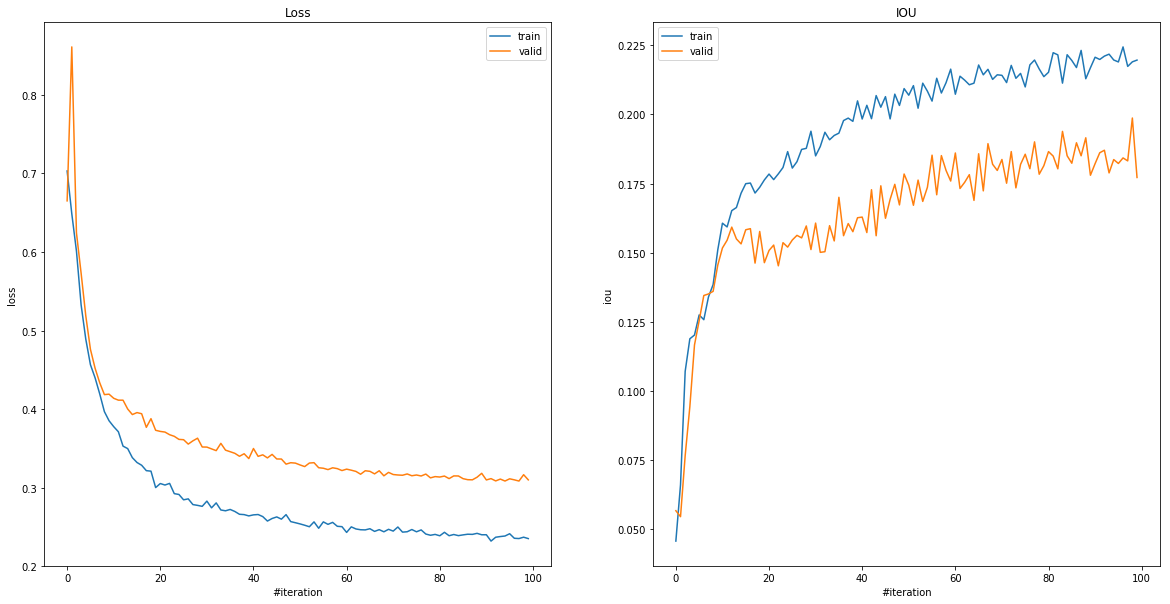

Epoch 100 of 100 time: 15.842s
  training loss (in-iteration): 	0.251625
  validation loss (in-iteration): 	0.309830
  train IOU: 			0.23
  validation IOU: 			0.18
  IOU time: 0.005889415740966797


In [15]:
.# UNet with batchnorm and threshold = 0.5
train(UNet(use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True})

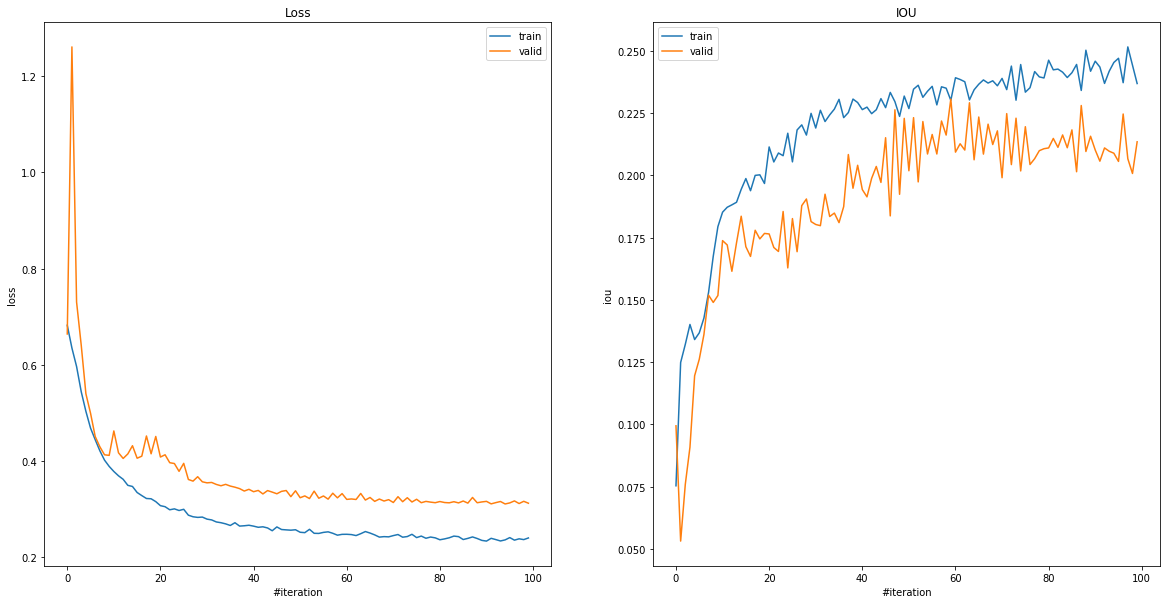

Epoch 100 of 100 time: 15.825s
  training loss (in-iteration): 	0.246488
  validation loss (in-iteration): 	0.311711
  train IOU: 			0.24
  validation IOU: 			0.21
  IOU time: 0.006167173385620117


In [16]:
# UNet with batchnorm and threshold = 0.6
train(UNet(use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.6)

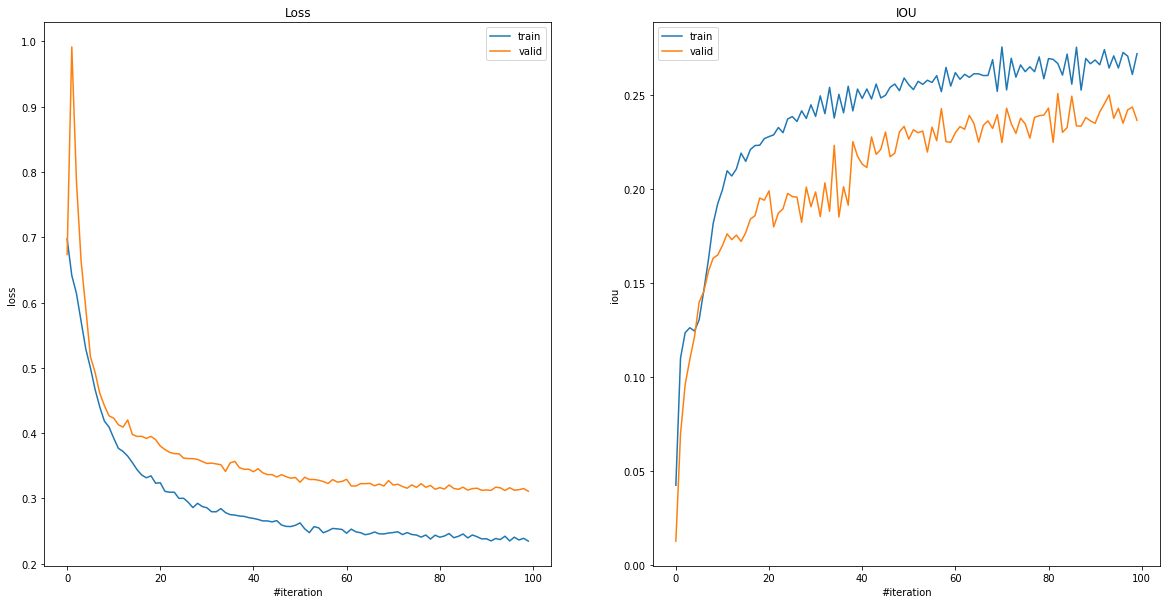

Epoch 100 of 100 time: 15.821s
  training loss (in-iteration): 	0.251268
  validation loss (in-iteration): 	0.311086
  train IOU: 			0.24
  validation IOU: 			0.24
  IOU time: 0.0061495304107666016


In [17]:
# UNet with batchnorm and threshold = 0.7
train(UNet(use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.7)

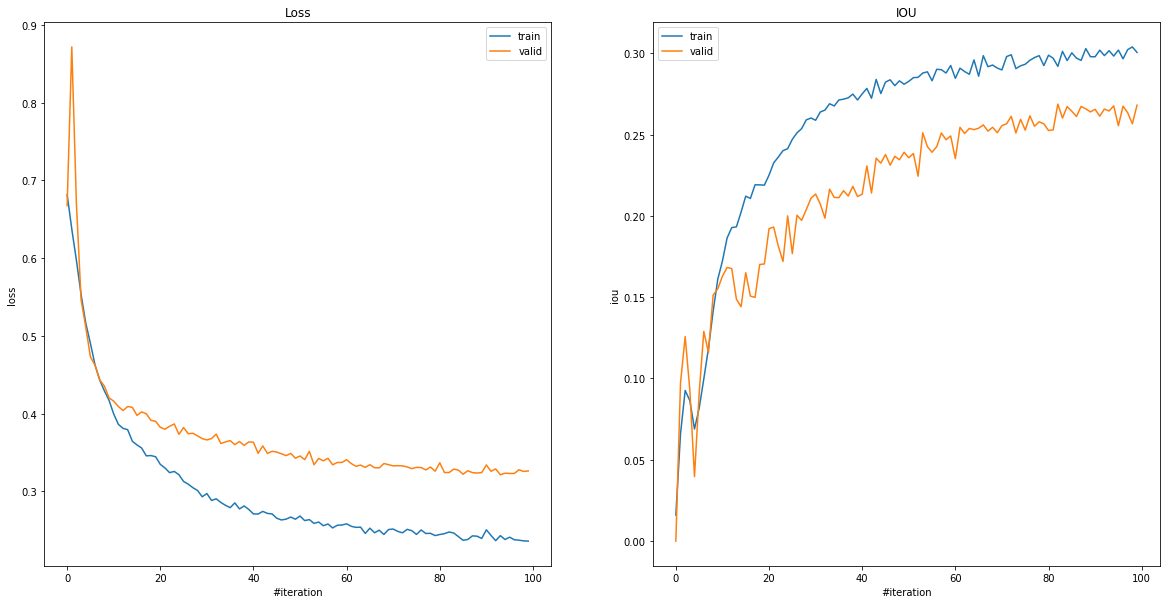

Epoch 100 of 100 time: 28.726s
  training loss (in-iteration): 	0.222322
  validation loss (in-iteration): 	0.326122
  train IOU: 			0.32
  validation IOU: 			0.27
  IOU time: 0.00639796257019043


In [15]:
# UNet with batchnorm and threshold = 0.8
train(UNet(use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.8)

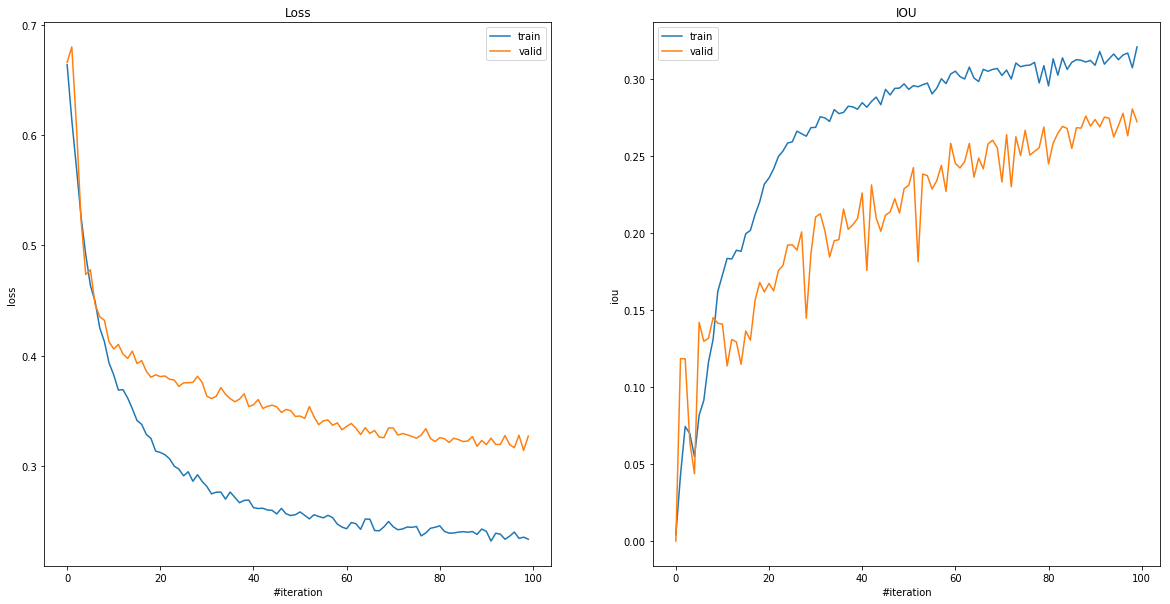

Epoch 100 of 100 time: 28.620s
  training loss (in-iteration): 	0.296487
  validation loss (in-iteration): 	0.327024
  train IOU: 			0.29
  validation IOU: 			0.27
  IOU time: 0.006648063659667969


In [16]:
# UNet with batchnorm and threshold = 0.85
train(UNet(use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.85)

Seems like 0.8 is the optimal threshold, as increasing it does not improve validation IOU.

From this moment on uisng threshold=0.8 .

Trying to add random rotations to augmentations.

In [22]:
train_data = ImagePairDataset("BBBC018_v1_images-fixed/train", "BBBC018_v1_outlines/train",
                              [torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.RandomRotation([5, 30]),
                               torchvision.transforms.RandomResizedCrop(size=512, 
                                                                        scale=(0.5, 1.0), 
                                                                        ratio=(0.5, 2)),
                               Pad(94, padding_mode="reflect"),
                               torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])
val_data = ImagePairDataset("BBBC018_v1_images-fixed/val", "BBBC018_v1_outlines/val",
                            [Pad(94, padding_mode="reflect"),
                             torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])

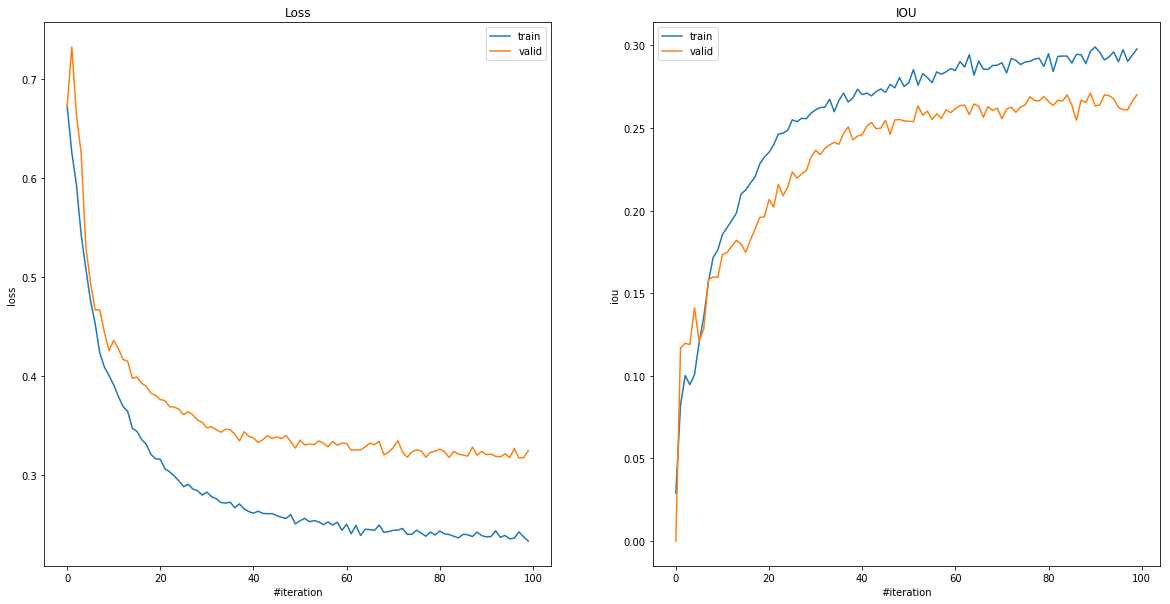

Epoch 100 of 100 time: 15.576s
  training loss (in-iteration): 	0.194726
  validation loss (in-iteration): 	0.324250
  train IOU: 			0.34
  validation IOU: 			0.27
  IOU time: 0.008378267288208008


In [23]:
train(UNet(use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.8)

Generalization improved!

Let's now try to convert all images to grayscale, because you can see more detail on grayscale images compared to colored ones. This should help with images that have large clusters of cells.
On colored images you can hardly make out cell borders inside the cluster, but on grayscale situation improves.

In [15]:
train_data = ImagePairDataset("BBBC018_v1_images-fixed/train", "BBBC018_v1_outlines/train",
                              [torchvision.transforms.Grayscale(),
                               torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.RandomRotation([5, 30]),
                               torchvision.transforms.RandomResizedCrop(size=512, 
                                                                        scale=(0.5, 1.0), 
                                                                        ratio=(0.5, 2)),
                               Pad(94, padding_mode="reflect"),
                               torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])
val_data = ImagePairDataset("BBBC018_v1_images-fixed/val", "BBBC018_v1_outlines/val",
                            [torchvision.transforms.Grayscale(),
                             Pad(94, padding_mode="reflect"),
                             torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])

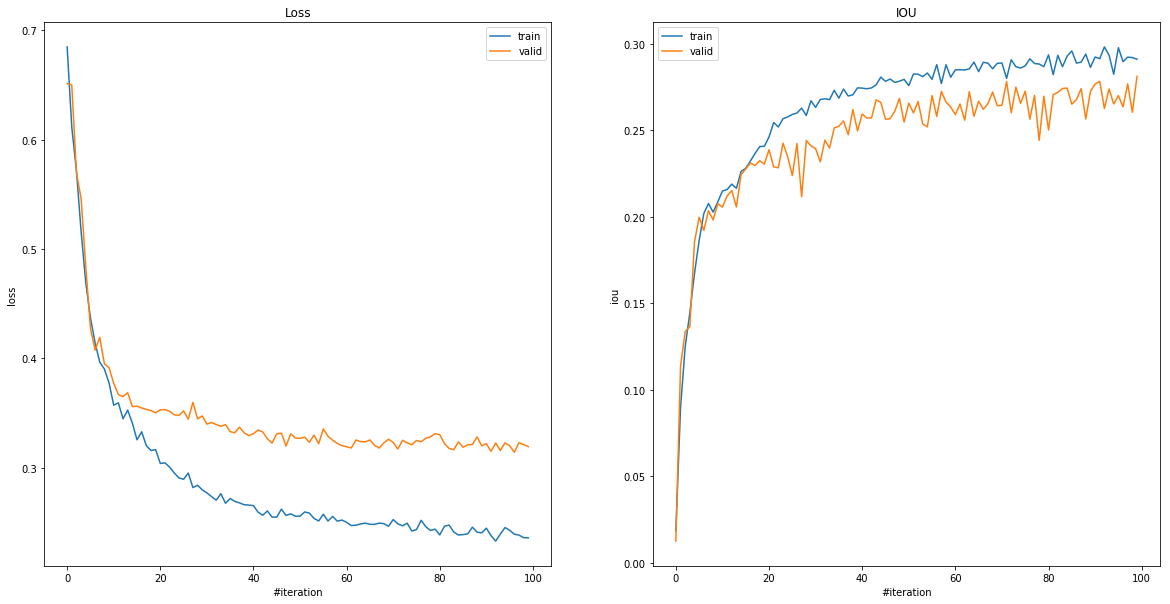

Epoch 100 of 100 time: 15.554s
  training loss (in-iteration): 	0.211295
  validation loss (in-iteration): 	0.319306
  train IOU: 			0.29
  validation IOU: 			0.28
  IOU time: 0.005790233612060547


In [16]:
train(UNet(num_channels=1, use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-4, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.8)

IOU improved!

Let's now try to increase learning rate, see if it converges better.

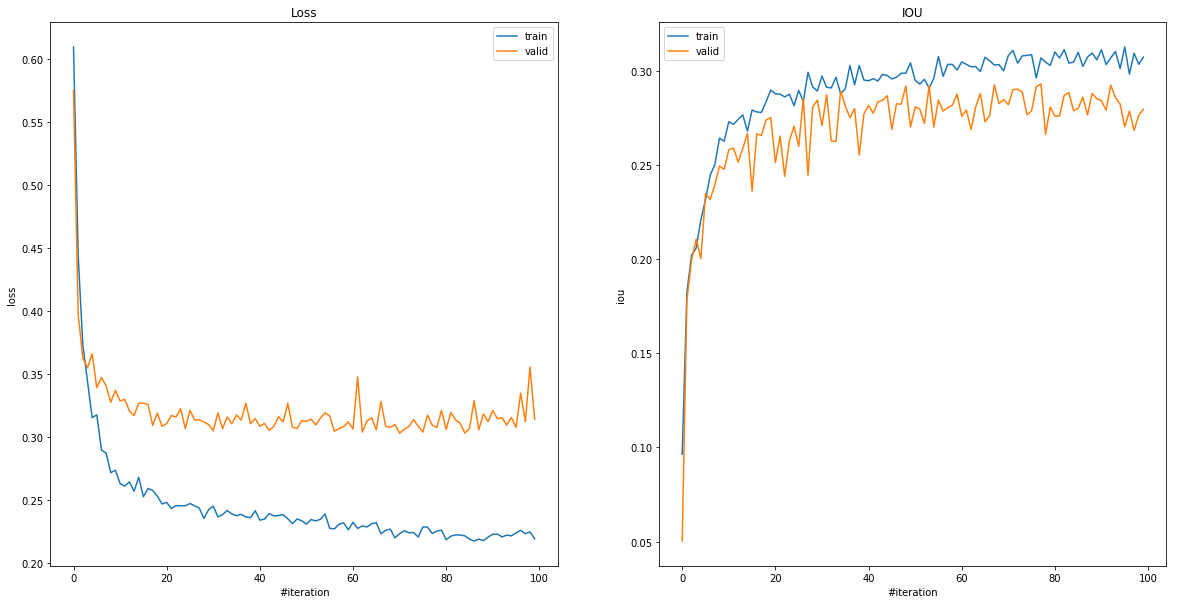

Epoch 100 of 100 time: 15.255s
  training loss (in-iteration): 	0.278468
  validation loss (in-iteration): 	0.313854
  train IOU: 			0.31
  validation IOU: 			0.28
  IOU time: 0.006082773208618164


In [17]:
train(UNet(num_channels=1, use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-3, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.8)

IOU didn't really improve, but convergence was faster.

Let's increase range of image rotation angles from 5 to 30 to 5 to 90.

In [14]:
train_data = ImagePairDataset("BBBC018_v1_images-fixed/train", "BBBC018_v1_outlines/train",
                              [torchvision.transforms.Grayscale(),
                               torchvision.transforms.RandomVerticalFlip(),
                               torchvision.transforms.RandomHorizontalFlip(),
                               torchvision.transforms.RandomRotation([5, 90]),
                               torchvision.transforms.RandomResizedCrop(size=512, 
                                                                        scale=(0.5, 1.0), 
                                                                        ratio=(0.5, 2)),
                               Pad(94, padding_mode="reflect"),
                               # torchvision.transforms.ToTensor()])
                               torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])
val_data = ImagePairDataset("BBBC018_v1_images-fixed/val", "BBBC018_v1_outlines/val",
                            [torchvision.transforms.Grayscale(),
                             Pad(94, padding_mode="reflect"),
                             torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])

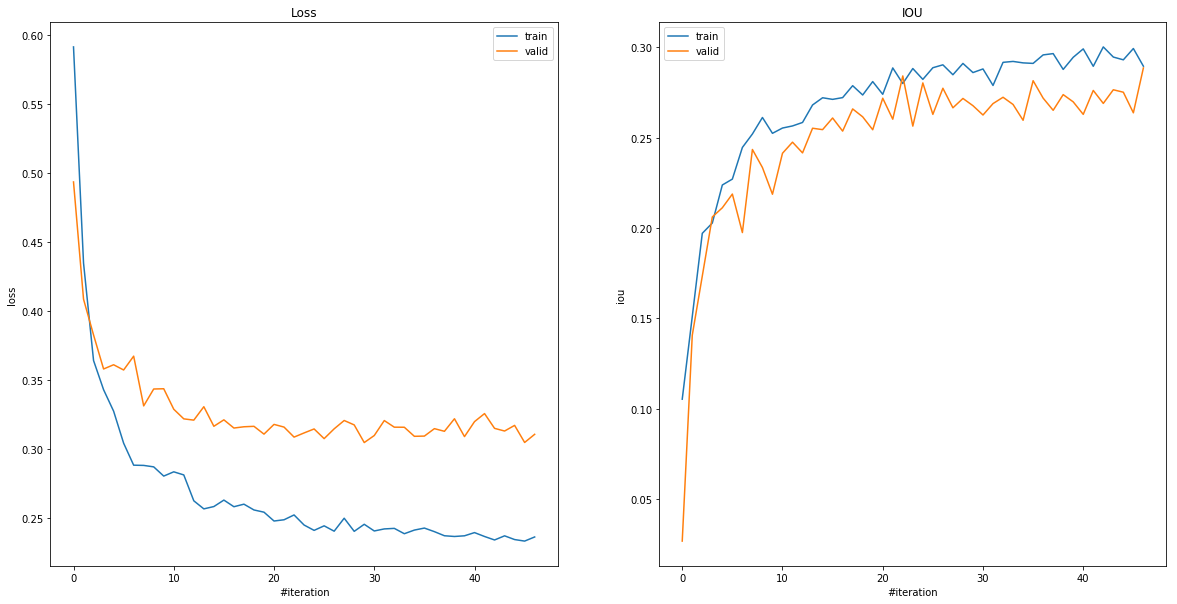

Epoch 47 of 100 time: 15.539s
  training loss (in-iteration): 	0.253175
  validation loss (in-iteration): 	0.310864
  train IOU: 			0.32
  validation IOU: 			0.29
  IOU time: 0.005989551544189453


RuntimeError: Achieved good IOU.

In [15]:
unet = UNet(num_channels=1, use_bn=True)
train(unet, train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-3, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.8, break_after=0.29)

Yay! We finally reached validation IOU >= 0.29. Let's save our model and load it for generating test images. (Otherwise it causes OOM on GPU)

In [16]:
torch.save(unet, "best_unet")

/home/penguin138/.virtualenvs/py3.6/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/penguin138/.virtualenvs/py3.6/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type DownwardConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/penguin138/.virtualenvs/py3.6/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type UpwardConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


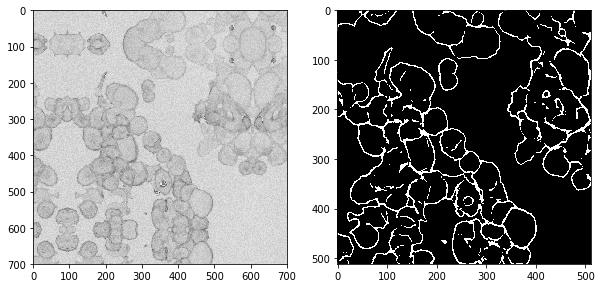

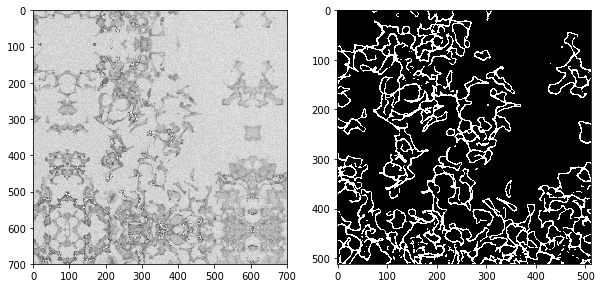

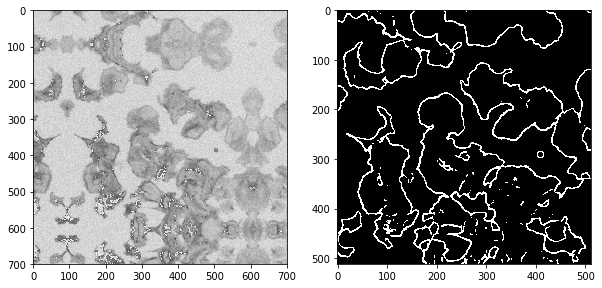

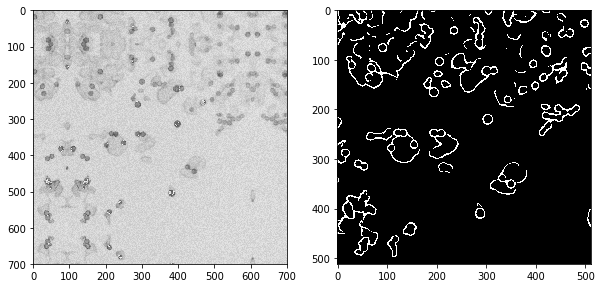

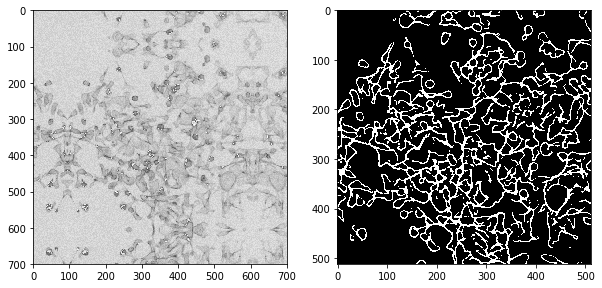

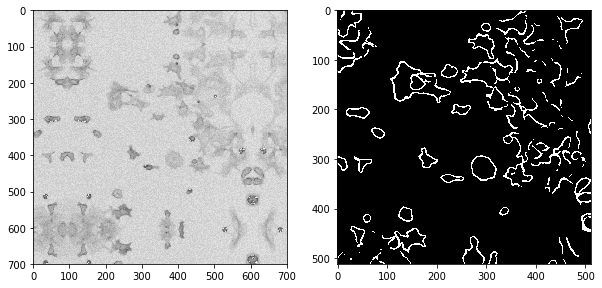

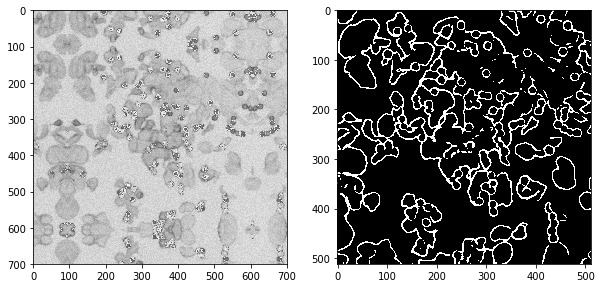

In [14]:
! mkdir -p test_results

unet = torch.load("best_unet")
test_data = ImagePairDataset("BBBC018_v1_images-fixed/test", "BBBC018_v1_images-fixed/test",
                            [torchvision.transforms.Grayscale(),
                             Pad(94, padding_mode="reflect"),
                             torchvision.transforms.Lambda(lambda img: np.asarray(img).astype(np.uint8))])
evaluate(unet, test_data, sorted(os.listdir("BBBC018_v1_images-fixed/test")),
         batch_size=1, prediction_threshold=0.8)

Result are not bad!

Note that test images shown on the left side were reflected to feed them to UNet.

So when comparing you should look at the center of original test image excluding reflected part.

So, even if we got good results. I still want to test one more thing: increasing threshold up to 0.9 to make borders look thinner. 

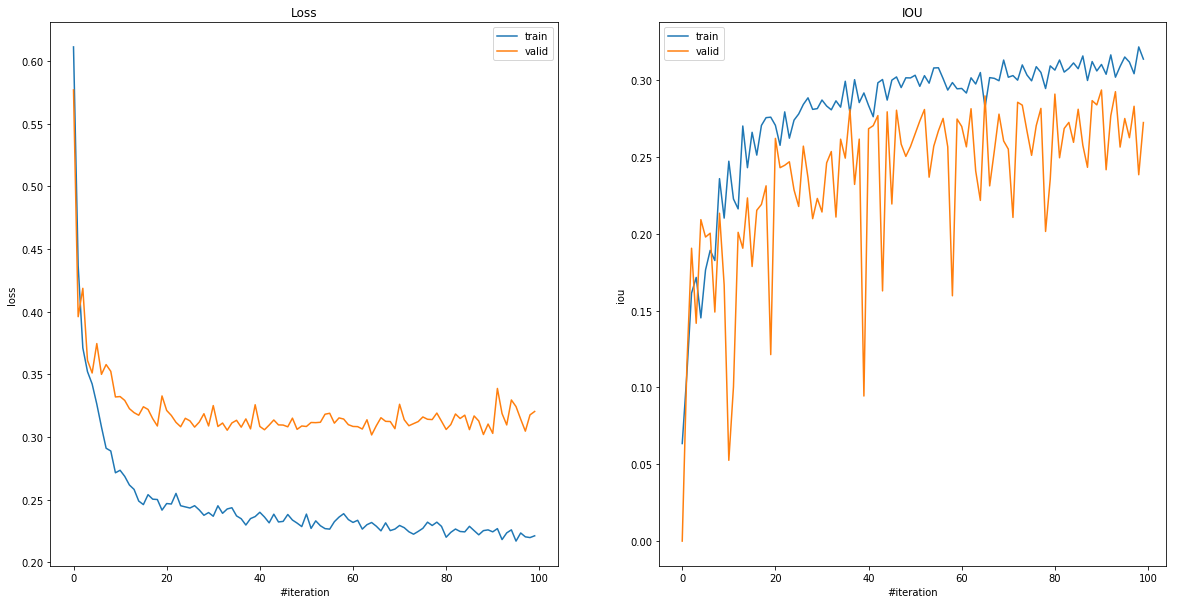

Epoch 100 of 100 time: 15.240s
  training loss (in-iteration): 	0.186431
  validation loss (in-iteration): 	0.320348
  train IOU: 			0.30
  validation IOU: 			0.27
  IOU time: 0.005913734436035156


In [20]:
train(UNet(num_channels=1, use_bn=True), train_data, val_data, batch_size=1, num_epochs=100,
      optimizer_type=torch.optim.SGD, optimizer_config={"lr": 1e-3, "momentum":0.99, "nesterov": True},
      prediction_threshold=0.9)

Nah! It only got worse...